In [1]:
# %%
# Import necessary libraries for data handling, model utilization, and visualization
import numpy as np
import pandas as pd
import yfinance as yf  # For collecting financial data
import matplotlib.pyplot as plt
from typing import List, Dict, Optional, Tuple
from datetime import datetime, timedelta
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from scipy.optimize import minimize
from collections import deque
# Import the custom Model class
from Model import Model
import logging
# Configure logging
logging.basicConfig(level=logging.INFO, format='%(levelname)s:%(message)s')

# Set the random seed for reproducibility across numpy and tensorflow
np.random.seed(123)
tf.random.set_seed(123)
# 
plt.style.use('seaborn-darkgrid')

# Define the tickers and date range with consideration of trading days
TICKERS = ['AGG', 'DBC', 'VTI', '^VIX']#, 'VEA', 'EEM', 'VNQ', 'IWM']

# Approximate number of trading days per year (useful for annualizing returns)
TRADING_DAYS_PER_YEAR = 252
# Define transaction cost rate
C = 0.0001  # 0.01%

# Confirm setup
print("Setup complete: libraries imported, random seed set, and tickers defined.")

Setup complete: libraries imported, random seed set, and tickers defined.


C:\Users\wiztu\AppData\Local\Temp\ipykernel_40620\2152488848.py:26: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


In [2]:
# %%
# Data Collection Step
# Objective: Fetch historical adjusted close prices for defined tickers and date range

# Download data using yfinance for the specified tickers and date range
def get_data(tickers, start_date, end_date):
    """
    Retrieves historical adjusted close prices for the given tickers and date range.
    
    Parameters:
    - tickers: List of stock ticker symbols
    - start_date: Start date for historical data
    - end_date: End date for historical data
    
    Returns:
    - DataFrame of adjusted close prices, with each column representing a ticker
    """
    # Fetch asset prices
    asset_data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
    asset_data.dropna(inplace=True)

    # Fetch risk-free rate (^IRX) which represents the 13-week Treasury Bill
    rf_ticker = '^IRX'
    rf_data = yf.download(rf_ticker, start=start_date, end=end_date)['Adj Close']
    rf_data = rf_data.resample('D').ffill()  # Forward-fill to get daily rates
    rf_data = rf_data / 100 / TRADING_DAYS_PER_YEAR  # Convert annual percentage to daily decimal

    # Combine asset data and risk-free rates
    data = asset_data.join(rf_data.rename('Risk_Free_Rate_Daily'), how='left')
    data['Risk_Free_Rate_Daily'].fillna(method='ffill', inplace=True)

    return data

# Fetch the data and display a quick preview
data = get_data(TICKERS, '2006-01-01', '2024-11-26')
print("Data fetched successfully. Sample data:")
print(data.head())

# Confirm data spans the expected range and has the expected number of columns
print(f"Data covers {len(data)} trading days with {len(data.columns)} assets.")

[*********************100%%**********************]  4 of 4 completed
[*********************100%%**********************]  1 of 1 completed

Data fetched successfully. Sample data:
                  AGG        DBC        VTI   ^VIX  Risk_Free_Rate_Daily
Date                                                                    
2006-02-06  56.300117  20.889498  44.654282  13.04              0.000173
2006-02-07  56.260777  20.285255  44.219490  13.59              0.000174
2006-02-08  56.232735  20.198935  44.537601  12.83              0.000174
2006-02-09  56.266453  20.388838  44.452789  13.12              0.000174
2006-02-10  56.148476  20.017662  44.544689  12.87              0.000176
Data covers 4734 trading days with 5 assets.



C:\Users\wiztu\AppData\Local\Temp\ipykernel_40620\2390651822.py:30: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['Risk_Free_Rate_Daily'].fillna(method='ffill', inplace=True)


In [3]:
# %%
def preprocess_data(data, rolling_window=50):
    """
    Prepares data by calculating window-day rolling averages and returns.

    Parameters:
    - data: DataFrame of historical adjusted close prices for assets
    - rolling_window: Window size for the rolling average

    Returns:
    - normalized_data: Smoothed prices, normalized to start at 1 for each asset
    - returns: Smoothed returns using a rolling mean of percentage changes
    """
    # Calculate rolling mean for prices and returns to smooth the data
    smoothed_prices = (data.rolling(window=rolling_window).mean()).dropna()
    smoothed_returns = (data.pct_change().rolling(window=rolling_window).mean()).dropna()
    # Normalize prices to start each asset's time series at 1
    normalized_data = smoothed_prices / smoothed_prices.iloc[0]
    
    return normalized_data, smoothed_returns


# Run preprocessing and display sample data
normalized_data, smoothed_returns = preprocess_data(data)
print("Data preprocessing complete. Sample normalized data:")
print(normalized_data.head())
print("\nSample daily returns:")
print(smoothed_returns.head())


Data preprocessing complete. Sample normalized data:
                 AGG       DBC       VTI      ^VIX  Risk_Free_Rate_Daily
Date                                                                    
2006-04-18  1.000000  1.000000  1.000000  1.000000              1.000000
2006-04-19  0.999786  1.001443  1.000798  0.997130              1.001134
2006-04-20  0.999555  1.003226  1.001815  0.993875              1.002113
2006-04-21  0.999332  1.005552  1.002683  0.991806              1.003149
2006-04-24  0.999172  1.007249  1.003528  0.989520              1.004150

Sample daily returns:
                 AGG       DBC       VTI      ^VIX  Risk_Free_Rate_Daily
Date                                                                    
2006-04-19 -0.000212  0.001441  0.000813 -0.001952              0.001147
2006-04-20 -0.000229  0.001788  0.001035 -0.002230              0.000986
2006-04-21 -0.000221  0.002295  0.000882 -0.001198              0.001040
2006-04-24 -0.000157  0.001709  0.000862 -0.0013

In [4]:
class Portfolio:
    def __init__(self, initial_cash: float, asset_names: List[str], transaction_cost: float = 0.0001):
        self.initial_cash = initial_cash
        self.current_value = initial_cash
        self.transaction_cost_rate = transaction_cost
        self.asset_names = asset_names
        self.current_weights = np.zeros(len(asset_names))
        self.portfolio_values = []
        self.weights_history = []
        self.dates = []
        self.transaction_cost = 0.0  # Initialize transaction cost

    def rebalance(self, new_weights: np.array):
        # Compute transaction costs
        if len(self.weights_history) == 0:
            transaction_cost = self.transaction_cost_rate * np.sum(np.abs(new_weights))
        else:
            transaction_cost = self.transaction_cost_rate * np.sum(np.abs(new_weights - self.current_weights))
        self.transaction_cost = transaction_cost * self.current_value
        self.current_weights = new_weights.copy()
        self.weights_history.append(self.current_weights.copy())

    def update_portfolio_value(self, asset_returns: np.array, current_date: pd.Timestamp):
        # Compute portfolio return
        portfolio_return = np.dot(self.current_weights, asset_returns)
        self.current_value = self.current_value * (1 + portfolio_return) - self.transaction_cost
        self.transaction_cost = 0.0
        self.portfolio_values.append(self.current_value)
        self.dates.append(current_date)
    
    def get_portfolio_values(self):
        return self.portfolio_values


In [5]:
def calculate_metrics(portfolio_values, risk_free_rates):
    """
    Calculates performance metrics for the portfolio, incorporating historical risk-free rates.

    Parameters:
    - portfolio_values: List of daily portfolio values over the testing period.
    - risk_free_rates: Array of daily risk-free rates corresponding to portfolio_returns.

    Returns:
    - metrics: Dictionary containing various performance metrics.
    """
    # Drop risk free rate from portfolio values
    portfolio_values = portfolio_values[:-1]
    # Convert portfolio values to daily returns
    portfolio_returns = np.diff(portfolio_values) / portfolio_values[:-1]
    
    # Ensure risk_free_rates aligns with portfolio_returns
    risk_free_rates = risk_free_rates[:len(portfolio_returns)]
    
    # Compute excess returns
    excess_returns = portfolio_returns - risk_free_rates

    # Number of days
    N = len(portfolio_returns)

    # Calculate Sharpe Ratio using excess returns
    mean_excess_return = np.mean(excess_returns)
    std_dev = np.std(portfolio_returns)  # Use actual returns for std dev
    sharpe_ratio = mean_excess_return / std_dev * np.sqrt(TRADING_DAYS_PER_YEAR)

    # Calculate Sortino Ratio
    downside_returns = excess_returns[excess_returns < 0]
    downside_std_dev = np.std(downside_returns) if len(downside_returns) > 0 else 0
    sortino_ratio = (mean_excess_return / downside_std_dev) * np.sqrt(TRADING_DAYS_PER_YEAR) if downside_std_dev != 0 else np.nan

    # Calculate Maximum Drawdown
    cumulative_max = np.maximum.accumulate(portfolio_values[:len(portfolio_returns)])
    drawdowns = (cumulative_max - portfolio_values[:len(cumulative_max)]) / cumulative_max
    max_drawdown = np.max(drawdowns)

    # Expected return (annualized)
    cumulative_return = (portfolio_values[-1] / portfolio_values[0])
    annualized_return = (cumulative_return) ** (TRADING_DAYS_PER_YEAR / N) - 1
    print(f"cumulative_return: {cumulative_return}, annualized_return: {annualized_return}")

    # Standard deviation of returns (annualized)
    annualized_std = std_dev * np.sqrt(TRADING_DAYS_PER_YEAR)

    # Percentage of positive returns
    positive_returns = portfolio_returns[portfolio_returns > 0]
    percentage_positive = len(positive_returns) / len(portfolio_returns) * 100

    # Average profit / average loss (profit/loss ratio)
    average_profit = np.mean(portfolio_returns[portfolio_returns > 0]) if len(positive_returns) > 0 else 0
    average_loss = np.mean(portfolio_returns[portfolio_returns < 0]) if len(portfolio_returns[portfolio_returns < 0]) > 0 else 0
    profit_loss_ratio = (average_profit / -average_loss) if average_loss != 0 else np.nan

    metrics = {
        "Annualized Return": annualized_return,
        "Annualized Std Dev": annualized_std,
        "Sharpe Ratio": sharpe_ratio,
        "Sortino Ratio": sortino_ratio,
        "Max Drawdown": max_drawdown,
        "% Positive Returns": percentage_positive,
        "Profit/Loss Ratio": profit_loss_ratio
    }
    
    return metrics


In [6]:
# %%
def equal_weighted_strategy(returns):
    """
    Creates an equal-weighted portfolio.

    Parameters:
    - returns: DataFrame of daily returns for each asset.

    Returns:
    - equal_weights: Numpy array of equal weights for each asset.
    """
    num_assets = returns.shape[1]
    equal_weights = np.ones(num_assets) / num_assets
    return equal_weights

# Define function to get MV weights
def mean_variance_optimized_strategy(returns, expected_rf, expected_returns=None):
    """
    Creates a mean-variance optimized portfolio by maximizing the Sharpe Ratio.

    Parameters:
    - returns: DataFrame of daily returns for each asset.
    - expected_rf: Expected risk-free rate (scalar)
    - expected_returns: Numpy array of expected returns (if provided, use this instead of historical mean returns)

    Returns:
    - optimized_weights: Numpy array of optimized weights for each asset.
    """
    if expected_returns is None:
        mean_returns = returns.mean() - expected_rf
    else:
        mean_returns = expected_returns - expected_rf  # Expected returns minus risk-free rate
    cov_matrix = returns.cov()

    def neg_sharpe(weights):
        portfolio_return = np.dot(weights, mean_returns)
        portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        return -portfolio_return / portfolio_std

    # Constraints: Weights must sum to 1, and each weight must be between 0 and 1
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for _ in range(returns.shape[1]))

    result = minimize(neg_sharpe, np.ones(returns.shape[1]) / returns.shape[1], bounds=bounds, constraints=constraints)
    optimized_weights = result.x
    optimized_weights = np.maximum(optimized_weights, 0)  # Avoid negative weights
    return optimized_weights

# Define function to get MD weights
def maximum_diversification(returns):
    """
    Perform maximum diversification optimization based on the given returns.

    Parameters:
    - returns: DataFrame of daily returns for each asset.

    Returns:
    - optimal_weights: Array of portfolio weights that maximize diversification.
    """
    # Calculate asset volatilities (standard deviation of each asset’s returns)
    asset_volatilities = returns.std()

    # Calculate the covariance matrix of returns
    cov_matrix = returns.cov()

    # Define the diversification ratio to be maximized
    def neg_diversification_ratio(weights):
        # Calculate the weighted average asset volatility
        weighted_volatility = np.dot(weights, asset_volatilities)
        
        # Calculate the portfolio volatility as the weighted covariance matrix
        portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        
        # Diversification ratio (we negate this because we want to maximize it)
        diversification_ratio = weighted_volatility / portfolio_volatility
        return -diversification_ratio  # Negate to turn this into a minimization problem

    # Constraints: weights sum to 1, and each weight between 0 and 1 (long-only portfolio)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for _ in range(len(asset_volatilities)))

    # Initial guess (equal allocation)
    init_guess = np.ones(len(asset_volatilities)) / len(asset_volatilities)

    # Optimize to find weights that maximize diversification ratio
    result = minimize(neg_diversification_ratio, init_guess, bounds=bounds, constraints=constraints)
    optimal_weights = result.x
    
    return optimal_weights


In [7]:
def average_metrics(metrics_list):
    """
    Calculates the average of each metric in the list of metrics.
    """
    avg_metrics = {}
    keys = metrics_list[0].keys()
    for key in keys:
        avg_metrics[key] = np.mean([m[key] for m in metrics_list])
    return avg_metrics


In [8]:
def plot_performance_comparison(portfolio_histories, periods, strategies):
    """
    Plots the actual portfolio values for each strategy across all testing periods in a grid format,
    swapping rows and columns such that rows represent strategies and columns represent periods.
    
    Parameters:
    - portfolio_histories: Dictionary containing portfolio value histories for each strategy.
    - periods: List of tuples containing (training_end, testing_start, testing_end) for each period.
    - strategies: List of strategy names to plot.
    """
    num_periods = len(periods)
    num_strategies = len(strategies)
    
    # Set up the matplotlib figure
    fig, axes = plt.subplots(num_strategies, num_periods, figsize=(5*num_periods, 3*num_strategies), sharex=False, sharey=False)
    fig.suptitle('Portfolio Performance Comparison (Raw Values)', fontsize=16, y=0.92)
    
    for strat_idx, strategy in enumerate(strategies):
        for period_idx, period in enumerate(periods):
            training_end, testing_start, testing_end = period
            
            # Handle axes indexing for single row or column
            if num_periods == 1 and num_strategies == 1:
                ax = axes
            elif num_periods == 1:
                ax = axes[strat_idx]
            elif num_strategies == 1:
                ax = axes[period_idx]
            else:
                ax = axes[strat_idx, period_idx]
            
            # Get the corresponding portfolio history
            history = portfolio_histories[strategy][period_idx]
            dates = history['dates']
            values = history['values']
            # Plot raw portfolio values
            ax.plot(dates, values, label=f"{strategy}")
            ax.set_title(f"{strategy} | {testing_start} to {testing_end}")
            ax.set_xlabel('Date')
            ax.set_ylabel('Portfolio Value ($)')
            ax.legend()
            ax.grid(True)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


In [9]:
def plot_weights_comparison(portfolio_histories, periods, strategies, asset_names):
    """
    Plots the portfolio weights for each strategy across all testing periods in a grid format,
    with each asset having its own line on the graph, colored differently and with a legend.

    Parameters:
    - portfolio_histories: Dictionary containing portfolio histories for each strategy.
      Each entry should have 'dates', 'values', and 'weights'.
    - periods: List of tuples containing (training_end, testing_start, testing_end) for each period.
    - strategies: List of strategy names to plot.
    - asset_names: List of asset names corresponding to portfolio weights.
    """
    num_periods = len(periods)
    num_strategies = len(strategies)
    
    # Set up the matplotlib figure
    fig, axes = plt.subplots(num_strategies, num_periods, figsize=(5*num_periods, 3*num_strategies), sharex=False, sharey=False)
    fig.suptitle('Portfolio Weights Comparison', fontsize=16, y=0.92)
    
    # If there's only one strategy or one period, adjust axes accordingly
    if num_strategies == 1 and num_periods == 1:
        axes = np.array([[axes]])
    elif num_strategies == 1:
        axes = np.expand_dims(axes, axis=0)
    elif num_periods == 1:
        axes = np.expand_dims(axes, axis=1)
    
    for strat_idx, strategy in enumerate(strategies):
        for period_idx, period in enumerate(periods):
            training_end, testing_start, testing_end = period
            
            ax = axes[strat_idx, period_idx]
            
            # Get the corresponding portfolio history
            history = portfolio_histories[strategy][period_idx]
            dates = history['dates']
            weights = np.array(history['weights'])  # Shape: (num_days, num_assets)
            
            # Create a DataFrame for easier plotting
            weights_df = pd.DataFrame(weights, index=dates, columns=asset_names)
            
            # Plot each asset's weight over time
            for asset in asset_names:
                ax.plot(weights_df.index, weights_df[asset], label=asset)
            
            ax.set_title(f"{strategy} | {testing_start} to {testing_end}")
            ax.set_xlabel('Date')
            ax.set_ylabel('Weight')
            ax.legend(fontsize='small', ncol=2)
            ax.grid(True)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


In [10]:
# %%
# Define testing periods
training_end_dates = ['2010-12-31', '2012-12-31', '2014-12-31', '2016-12-31', '2018-12-31','2020-12-31','2022-12-31']
testing_start_dates = ['2011-01-01', '2013-01-01', '2015-01-01', '2017-01-01', '2019-01-01' ,'2021-01-01','2023-01-01']
testing_end_dates = ['2012-12-31', '2014-12-31', '2016-12-31', '2018-12-31', '2020-12-31','2022-12-31','2024-11-25']

periods = list(zip(training_end_dates, testing_start_dates, testing_end_dates))

# Initialize lists to store performance metrics for each model
lstm_metrics = []
mvo_metrics = []
md_metrics = []
ew_metrics = []
# Initialize a dictionary to store portfolio histories for each strategy
portfolio_histories = {
    'LSTM': [],
    'MVO': [],
    'MD': [],
    'EW': [],
}

initial_cash = 100000

In [ ]:
def run_backtest(data, periods, initial_cash, C, rebalancing_frequency=1, lstm_window_size=50, mvo_md_window_size=50):
    portfolio_histories = {
        'LSTM': [],
        'MVO': [],
        'MD': [],
        'EW': [],
    }
    lstm_metrics = []
    mvo_metrics = []
    md_metrics = []
    ew_metrics = []
    for period in periods:
        training_end, testing_start, testing_end = period
        print(f"\nProcessing period: Training up to {training_end}, Testing from {testing_start} to {testing_end}")

        # Split the data into training and testing sets
        training_data = data.loc[:training_end].copy()
        testing_data = data.loc[testing_start:testing_end].copy()
        testing_returns = testing_data.pct_change().fillna(0)
        testing_returns = testing_returns.drop('Risk_Free_Rate_Daily', axis=1)
        # Ensure there is enough data for testing
        if len(testing_data) < 1:
            print("Not enough data for testing period")
            continue

        # -------------------------------------------
        # LSTM Model
        # -------------------------------------------

        # Train the LSTM model
        lstm_model = Model()
        lstm_model.train(training_data)

        # Initialize the portfolio for LSTM strategy
        portfolio_lstm = Portfolio(
            initial_cash,
            asset_names=testing_returns.columns.tolist(),
            transaction_cost=C
        )

        # Combine the last 'lstm_window_size' days of training data with the testing data
        combined_data = pd.concat(
            [training_data.tail(lstm_window_size), testing_data],
            ignore_index=False
        )

        # Calculate daily returns
        returns = combined_data.drop('Risk_Free_Rate_Daily', axis=1).pct_change().fillna(0)

        # Ensure 'Risk_Free_Rate_Daily' is present in combined_data
        if 'Risk_Free_Rate_Daily' not in combined_data.columns:
            # Fetch risk-free rate data
            rf_data = data.loc[combined_data.index, 'Risk_Free_Rate_Daily']
            combined_data = combined_data.join(rf_data.rename('Risk_Free_Rate_Daily'))

        # Create combined_data similar to training
        combined_data = pd.concat([combined_data, returns], axis=1)

        # Assign correct column names
        combined_data.columns = [f"{ticker}_price" for ticker in testing_returns.columns] + \
                                [f"{ticker}_return" for ticker in testing_returns.columns] + \
                                ['Risk_Free_Rate_Daily']
        
        last_rebalance_day = -rebalancing_frequency  # Ensure the first day is a rebalance

        # Now, in the loop, we can get input_sequence directly
        for idx, current_date in enumerate(testing_data.index):
            # Calculate the end index for the input sequence in combined_data
            end_idx = lstm_window_size + idx  # idx starts from 0

            # Check if it's time to rebalance
            if (idx - last_rebalance_day) >= rebalancing_frequency or idx == 0:
                # Extract the input sequence: the preceding 'lstm_window_size' days
                input_sequence = combined_data.iloc[end_idx - lstm_window_size:end_idx].values

                # Predict the allocation using the LSTM model
                allocation = lstm_model.predict_allocation(input_sequence)

                # Rebalance the portfolio with the new allocation
                portfolio_lstm.rebalance(allocation)

                last_rebalance_day = idx  # Update last rebalance day
            else:
                portfolio_lstm.weights_history.append(portfolio_lstm.weights_history[-1])
            
            # Get today's return
            today_return = testing_returns.iloc[idx].values

            # Update the portfolio value based on today's return
            portfolio_lstm.update_portfolio_value(today_return, current_date)

        # Store the LSTM portfolio history
        portfolio_values_lstm = portfolio_lstm.get_portfolio_values()
        portfolio_dates_lstm = portfolio_lstm.dates
        portfolio_histories['LSTM'].append({
            'dates': portfolio_dates_lstm,
            'values': portfolio_values_lstm,
            'weights': portfolio_lstm.weights_history
        })

        # Calculate and store performance metrics for LSTM
        metrics_lstm = calculate_metrics(
            portfolio_values_lstm, 
            data.loc[testing_start:testing_end, 'Risk_Free_Rate_Daily'].values
        )
        lstm_metrics.append(metrics_lstm)

        # -------------------------------------------
        # Mean-Variance Optimization (MVO) Model
        # -------------------------------------------

        # Calculate full returns up to the end of the testing period
        returns_full_testing = data.loc[:testing_end].pct_change().dropna()
        returns_full_testing = returns_full_testing.drop('Risk_Free_Rate_Daily', axis=1)
        # Returns only for the testing period
        returns_testing = data.loc[testing_start:testing_end].pct_change().dropna()
        returns_testing = returns_testing.drop('Risk_Free_Rate_Daily', axis=1)
        # Get indices of testing dates in returns_full_testing
        testing_indices = returns_full_testing.index.get_indexer_for(returns_testing.index)

        # Initialize the portfolio for MVO strategy
        portfolio_mv = Portfolio(
            initial_cash,
            asset_names=testing_returns.columns.tolist(),
            transaction_cost=C
        )

        # Initialize a variable to track rebalancing schedule
        last_rebalance_day = -rebalancing_frequency  # Ensure the first day is a rebalance

        for idx, i in enumerate(testing_indices):
            # i is the index in returns_full_testing corresponding to the current testing day
            current_date = returns_testing.index[idx]

            # Check if it's time to rebalance
            if (idx - last_rebalance_day) >= rebalancing_frequency or idx == 0:
                # Ensure we have enough data for the window
                if i >= mvo_md_window_size - 1:
                    # Extract the past 'mvo_md_window_size' days of returns ending on current date
                    input_data = returns_full_testing.iloc[i - mvo_md_window_size + 1:i + 1]
                    # Extract corresponding risk-free rates
                    rf_data = data.loc[input_data.index, 'Risk_Free_Rate_Daily']
                    expected_rf = rf_data.mean()  # Calculate expected risk-free rate
                else:
                    # Not enough data, skip rebalancing
                    print(f"Not enough data for MVO window on {current_date}")
                    input_data = returns_full_testing.iloc[:i + 1]
                    rf_data = data.loc[input_data.index, 'Risk_Free_Rate_Daily']
                    expected_rf = rf_data.mean()  # Calculate expected risk-free rate

                weights_mv = mean_variance_optimized_strategy(input_data, expected_rf)  # Pass expected_rf

                # Rebalance the portfolio with MVO weights
                portfolio_mv.rebalance(weights_mv)

                last_rebalance_day = idx  # Update last rebalance day
            else:
                # Maintain previous weights
                portfolio_mv.weights_history.append(portfolio_mv.weights_history[-1])

            # Get today's return
            today_return = returns_testing.iloc[idx].values

            # Update portfolio value
            portfolio_mv.update_portfolio_value(today_return, current_date)

        # Store MVO portfolio history
        portfolio_values_mv = portfolio_mv.get_portfolio_values()
        portfolio_dates_mv = portfolio_mv.dates
        portfolio_histories['MVO'].append({
            'dates': portfolio_dates_mv,
            'values': portfolio_values_mv,
            'weights': portfolio_mv.weights_history
        })

        # Calculate and store performance metrics for MVO
        metrics_mv = calculate_metrics(
            portfolio_values_mv, 
            data.loc[testing_start:testing_end, 'Risk_Free_Rate_Daily'].values
        )
        mvo_metrics.append(metrics_mv)

        # -------------------------------------------
        # Maximum Diversification (MD) Model
        # -------------------------------------------

        # Initialize the portfolio for MD strategy
        portfolio_md = Portfolio(
            initial_cash,
            asset_names=testing_returns.columns.tolist(),
            transaction_cost=C
        )

        # Initialize a variable to track rebalancing schedule
        last_rebalance_day = -rebalancing_frequency  # Ensure the first day is a rebalance

        for idx, i in enumerate(testing_indices):
            # i is the index in returns_full_testing corresponding to the current testing day
            current_date = returns_testing.index[idx]

            # Check if it's time to rebalance
            if (idx - last_rebalance_day) >= rebalancing_frequency or idx == 0:
                # Ensure we have enough data for the window
                if i >= mvo_md_window_size - 1:
                    # Extract the past 'mvo_md_window_size' days of returns ending on current date
                    input_data = returns_full_testing.iloc[i - mvo_md_window_size + 1:i + 1]
                else:
                    # Not enough data, skip rebalancing
                    print(f"Not enough data for MD window on {current_date}")
                    input_data = returns_full_testing.iloc[:i + 1]

                weights_md = maximum_diversification(input_data)

                # Rebalance the portfolio with MD weights
                portfolio_md.rebalance(weights_md)

                last_rebalance_day = idx  # Update last rebalance day
            else:
                # Maintain previous weights
                portfolio_md.weights_history.append(portfolio_md.weights_history[-1])

            # Get today's return
            today_return = returns_testing.iloc[idx].values

            # Update portfolio value
            portfolio_md.update_portfolio_value(today_return, current_date)

        # Store MD portfolio history
        portfolio_values_md = portfolio_md.get_portfolio_values()
        portfolio_dates_md = portfolio_md.dates
        portfolio_histories['MD'].append({
            'dates': portfolio_dates_md,
            'values': portfolio_values_md,
            'weights': portfolio_md.weights_history
        })

        # Calculate and store performance metrics for MD
        metrics_md = calculate_metrics(
            portfolio_values_md, 
            data.loc[testing_start:testing_end, 'Risk_Free_Rate_Daily'].values
        )
        md_metrics.append(metrics_md)

        # -------------------------------------------
        # Equal Weighted (EW) Strategy
        # -------------------------------------------

        # Initialize the portfolio for EW strategy
        portfolio_ew = Portfolio(
            initial_cash,
            asset_names=testing_returns.columns.tolist(),
            transaction_cost=C
        )

        weights_ew = equal_weighted_strategy(returns_full_testing)

        for idx in range(len(testing_returns)):
            today_return = testing_returns.iloc[idx].values
            current_date = testing_returns.index[idx]
            if idx % 252 == 0:
                # Rebalance yearly
                portfolio_ew.rebalance(weights_ew)
            else:
                # Maintain previous weights
                portfolio_ew.weights_history.append(portfolio_ew.weights_history[-1])
            # print(f"EW weights: {weights_ew}", f"EW portfolio value: {portfolio_ew.current_value}")
            portfolio_ew.update_portfolio_value(today_return, current_date)

        # Store EW portfolio history
        portfolio_values_ew = portfolio_ew.get_portfolio_values()
        portfolio_dates_ew = portfolio_ew.dates
        portfolio_histories['EW'].append({
            'dates': portfolio_dates_ew,
            'values': portfolio_values_ew,
            'weights': portfolio_ew.weights_history
        })

        # Calculate and store performance metrics for EW
        metrics_ew = calculate_metrics(
            portfolio_values_ew, 
            data.loc[testing_start:testing_end, 'Risk_Free_Rate_Daily'].values
        )
        ew_metrics.append(metrics_ew)

    # Return the portfolio histories and metrics
    return portfolio_histories, lstm_metrics, mvo_metrics, md_metrics, ew_metrics


In [12]:
# Run the backtest with 4 ETF tickers, rebalancing frequency 1
portfolio_histories, lstm_metrics, mvo_metrics, md_metrics, ew_metrics = run_backtest(
    data,
    periods,
    initial_cash,
    C,
    rebalancing_frequency=1,
    lstm_window_size=50,
    mvo_md_window_size=50,
)


Processing period: Training up to 2010-12-31, Testing from 2011-01-01 to 2012-12-31
Epoch 1/100


c:\Users\wiztu\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0229
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0042
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: -0.0063
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: -0.0171
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: -0.0330
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: -0.0567
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: -0.0776
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: -0.0835
Epoch 9/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: -0.0909
Epoch 10/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: -0.0940
Epoch 11/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: -0.1029
Epoch 12/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: -0.1083
Epoch 13/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: -0.1047
Epoch 14/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: -0.1104
Epoch 15/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - lo

c:\Users\wiztu\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: -0.0177
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: -0.0457
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: -0.0695
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: -0.0884
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: -0.1079
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: -0.1214
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: -0.1322
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: -0.1385
Epoch 9/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: -0.1414
Epoch 10/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: -0.1471
Epoch 11/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: -0.1524
Epoch 12/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: -0.1555
Epoch 13/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: -0.1565
Epoch 14/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: -0.1569
Epoch 15/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - 

c:\Users\wiztu\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: -0.0524
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: -0.0795
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: -0.1066
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: -0.1541
Epoch 5/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: -0.1826
Epoch 6/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: -0.1846
Epoch 7/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: -0.1938
Epoch 8/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: -0.1773
Epoch 9/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: -0.2014
Epoch 10/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: -0.1935
Epoch 11/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: -0.2018
Epoch 12/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: -0.1821
Epoch 13/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: -0.2040
Epoch 14/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: -0.2055
Epoch 15/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - 

c:\Users\wiztu\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: -0.0572
Epoch 2/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: -0.0935
Epoch 3/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: -0.1054
Epoch 4/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: -0.1364
Epoch 5/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: -0.1507
Epoch 6/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: -0.1546
Epoch 7/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: -0.1593
Epoch 8/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: -0.1623
Epoch 9/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: -0.1621
Epoch 10/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: -0.1615
Epoch 11/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: -0.1653
Epoch 12/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: -0.1701
Epoch 13/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: -0.1701
Epoch 14/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: -0.1733
Epoch 15/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - 

c:\Users\wiztu\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: -0.0332
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: -0.0563
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: -0.0742
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: -0.0914
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: -0.1017
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: -0.1075
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: -0.1140
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: -0.1237
Epoch 9/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: -0.1313
Epoch 10/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: -0.1313
Epoch 11/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: -0.1408
Epoch 12/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: -0.1415
Epoch 13/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: -0.1456
Epoch 14/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: -0.1478
Epoch 15/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - 

c:\Users\wiztu\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: -0.0623
Epoch 2/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: -0.1251
Epoch 3/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: -0.1401
Epoch 4/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: -0.1399
Epoch 5/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: -0.1488
Epoch 6/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: -0.1558
Epoch 7/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: -0.1574
Epoch 8/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: -0.1562
Epoch 9/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: -0.1659
Epoch 10/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: -0.1714
Epoch 11/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: -0.1768
Epoch 12/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: -0.1825
Epoch 13/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: -0.1754
Epoch 14/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: -0.1886
Epoch 15/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - 

c:\Users\wiztu\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: -0.0680
Epoch 2/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: -0.0975
Epoch 3/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: -0.1119
Epoch 4/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: -0.1308
Epoch 5/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: -0.1533
Epoch 6/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: -0.1582
Epoch 7/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: -0.1692
Epoch 8/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: -0.1717
Epoch 9/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: -0.1788
Epoch 10/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: -0.1700
Epoch 11/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: -0.1871
Epoch 12/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: -0.1830
Epoch 13/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: -0.1811
Epoch 14/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: -0.1848
Epoch 15/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - 

In [13]:
# Calculate average metrics for each model
lstm_avg_metrics = average_metrics(lstm_metrics)
mvo_avg_metrics = average_metrics(mvo_metrics)
md_avg_metrics = average_metrics(md_metrics)
ew_avg_metrics = average_metrics(ew_metrics)

In [14]:
# Print the average metrics
print("\nAverage Metrics for LSTM Model:")
for key, value in lstm_avg_metrics.items():
    print(f"{key}: {value:.4f}")

print("\nAverage Metrics for MVO Strategy:")
for key, value in mvo_avg_metrics.items():
    print(f"{key}: {value:.4f}")

print("\nAverage Metrics for MD Strategy:")
for key, value in md_avg_metrics.items():
    print(f"{key}: {value:.4f}")

print("\nAverage Metrics for Equal Weighted Strategy:")
for key, value in average_metrics(ew_metrics).items():
    print(f"{key}: {value:.4f}")



Average Metrics for LSTM Model:
Annualized Return: 0.3290
Annualized Std Dev: 0.1172
Sharpe Ratio: 2.3495
Sortino Ratio: 4.4690
Max Drawdown: 0.0607
% Positive Returns: 54.7035
Profit/Loss Ratio: 1.3610

Average Metrics for MVO Strategy:
Annualized Return: 0.2175
Annualized Std Dev: 0.1481
Sharpe Ratio: 2.0629
Sortino Ratio: 3.1466
Max Drawdown: 0.1543
% Positive Returns: 61.1732
Profit/Loss Ratio: 1.0849

Average Metrics for MD Strategy:
Annualized Return: 0.1071
Annualized Std Dev: 0.0518
Sharpe Ratio: 1.9044
Sortino Ratio: 2.9156
Max Drawdown: 0.0517
% Positive Returns: 57.3087
Profit/Loss Ratio: 1.0882

Average Metrics for Equal Weighted Strategy:
Annualized Return: 0.2231
Annualized Std Dev: 0.2844
Sharpe Ratio: 0.7872
Sortino Ratio: 1.6703
Max Drawdown: 0.1648
% Positive Returns: 46.8071
Profit/Loss Ratio: 1.3325


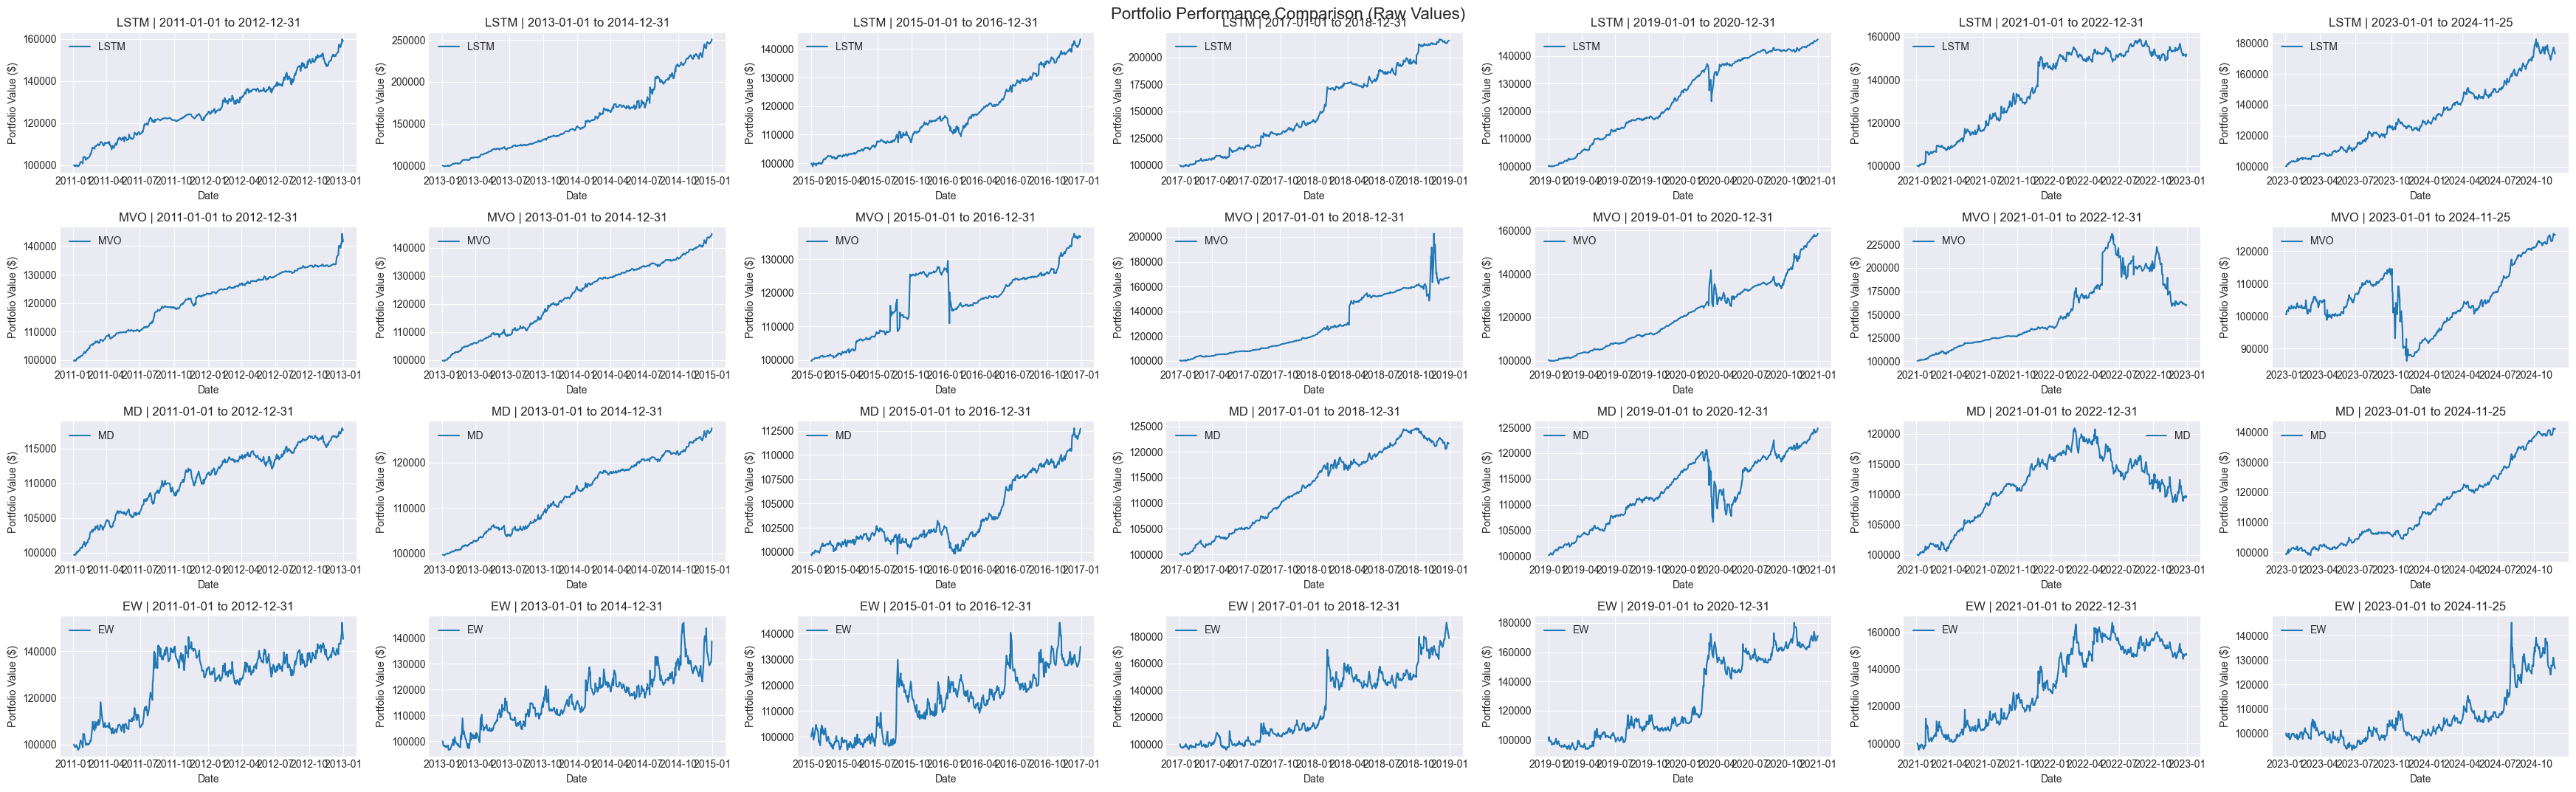

Period 1
LSTM Metrics:
Annualized Return: 0.2668
Annualized Std Dev: 0.0991
Sharpe Ratio: 2.4308
Sortino Ratio: 4.3598
Max Drawdown: 0.0411
% Positive Returns: 55.0000
Profit/Loss Ratio: 1.2583
MVO Metrics:
Annualized Return: 0.2057
Annualized Std Dev: 0.0451
Sharpe Ratio: 4.1556
Sortino Ratio: 9.1409
Max Drawdown: 0.0217
% Positive Returns: 59.7194
Profit/Loss Ratio: 1.5788
MD Metrics:
Annualized Return: 0.0884
Annualized Std Dev: 0.0379
Sharpe Ratio: 2.2368
Sortino Ratio: 3.5736
Max Drawdown: 0.0225
% Positive Returns: 56.1122
Profit/Loss Ratio: 1.1250
EW Metrics:
Annualized Return: 0.2362
Annualized Std Dev: 0.2473
Sharpe Ratio: 0.9771
Sortino Ratio: 2.1000
Max Drawdown: 0.1409
% Positive Returns: 48.0000
Profit/Loss Ratio: 1.2874


Period 2
LSTM Metrics:
Annualized Return: 0.5793
Annualized Std Dev: 0.1630
Sharpe Ratio: 2.8839
Sortino Ratio: 5.6373
Max Drawdown: 0.0515
% Positive Returns: 56.7729
Profit/Loss Ratio: 1.4064
MVO Metrics:
Annualized Return: 0.2038
Annualized Std Dev: 0

In [15]:
strategies = ['LSTM','MVO', 'MD', 'EW']
plot_performance_comparison(portfolio_histories, periods, strategies)
for i in range(len(mvo_metrics)):
    print(f"Period {i+1}")
    print("LSTM Metrics:")
    for key, value in lstm_metrics[i].items():
        print(f"{key}: {value:.4f}")
    print("MVO Metrics:")
    for key, value in mvo_metrics[i].items():
        print(f"{key}: {value:.4f}")
    print("MD Metrics:")
    for key, value in md_metrics[i].items():
        print(f"{key}: {value:.4f}")
    print("EW Metrics:")
    for key, value in ew_metrics[i].items():
        print(f"{key}: {value:.4f}")
    print("\n")

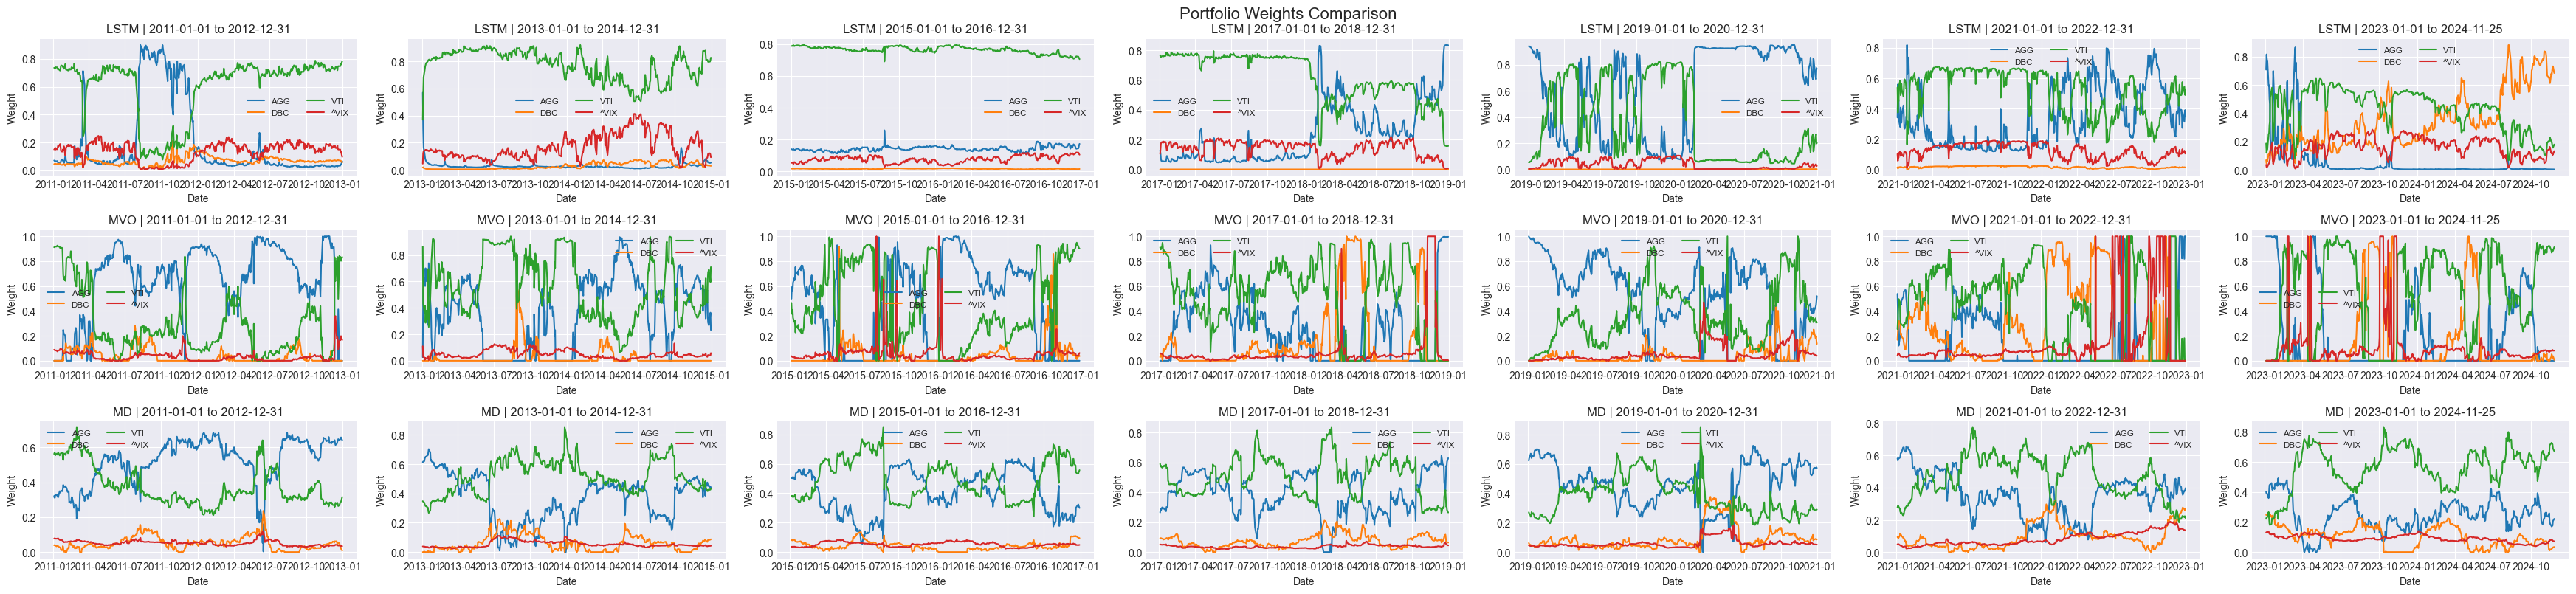

In [16]:
strategies = ['LSTM','MVO', 'MD']
asset_names = TICKERS
plot_weights_comparison(portfolio_histories, periods, strategies, asset_names)

In [20]:
TICKERS = ['AAPL','AMZN','NFLX','GOOG']
data = get_data(TICKERS, '2006-01-01', '2024-11-26')
portfolio_histories, lstm_metrics, mvo_metrics, md_metrics, ew_metrics = run_backtest(
    data,
    periods,
    initial_cash,
    C,
    rebalancing_frequency=1,
    lstm_window_size=50,
    mvo_md_window_size=50,
)

[*********************100%%**********************]  4 of 4 completed
[*********************100%%**********************]  1 of 1 completed
C:\Users\wiztu\AppData\Local\Temp\ipykernel_40620\2390651822.py:30: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['Risk_Free_Rate_Daily'].fillna(method='ffill', inplace=True)



Processing period: Training up to 2010-12-31, Testing from 2011-01-01 to 2012-12-31
Epoch 1/100


c:\Users\wiztu\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: -0.0897
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: -0.1001
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: -0.1031
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: -0.1059
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: -0.1092
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: -0.1126
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: -0.1159
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: -0.1097
Epoch 9/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: -0.1210
Epoch 10/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: -0.1088
Epoch 11/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: -0.1150
Epoch 12/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: -0.1175
Epoch 13/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: -0.1209
Epoch 14/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: -0.1226
Epoch 15/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - 

c:\Users\wiztu\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: -0.0442
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: -0.0586
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: -0.0647
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: -0.0670
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: -0.0695
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: -0.0722
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: -0.0706
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: -0.0727
Epoch 9/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: -0.0768
Epoch 10/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: -0.0766
Epoch 11/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: -0.0766
Epoch 12/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: -0.0753
Epoch 13/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: -0.0730
Epoch 14/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: -0.0789
Epoch 15/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - 

c:\Users\wiztu\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: -0.0713
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: -0.0886
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: -0.0927
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: -0.0962
Epoch 5/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: -0.0981
Epoch 6/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: -0.0991
Epoch 7/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: -0.1033
Epoch 8/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: -0.1031
Epoch 9/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: -0.1074
Epoch 10/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: -0.1057
Epoch 11/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: -0.1087
Epoch 12/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: -0.1102
Epoch 13/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: -0.1107
Epoch 14/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: -0.1115
Epoch 15/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - 

c:\Users\wiztu\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: -0.0684
Epoch 2/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: -0.0755
Epoch 3/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: -0.0768
Epoch 4/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: -0.0781
Epoch 5/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: -0.0778
Epoch 6/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: -0.0806
Epoch 7/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: -0.0827
Epoch 8/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: -0.0818
Epoch 9/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: -0.0844
Epoch 10/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: -0.0849
Epoch 11/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: -0.0850
Epoch 12/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: -0.0911
Epoch 13/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: -0.0867
Epoch 14/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: -0.0827
Epoch 15/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - 

c:\Users\wiztu\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: -0.0849
Epoch 2/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: -0.0990
Epoch 3/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: -0.0948
Epoch 4/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: -0.0956
Epoch 5/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: -0.0986
Epoch 6/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: -0.0987
Epoch 7/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: -0.0994
Epoch 8/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: -0.1012
Epoch 9/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: -0.0991
Epoch 10/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: -0.1002
Epoch 11/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: -0.1027
Epoch 12/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: -0.1023
Epoch 13/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: -0.1023
Epoch 14/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: -0.1038
Epoch 15/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - 

c:\Users\wiztu\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: -0.0642
Epoch 2/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: -0.0786
Epoch 3/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: -0.0826
Epoch 4/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: -0.0835
Epoch 5/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: -0.0847
Epoch 6/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: -0.0864
Epoch 7/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: -0.0842
Epoch 8/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: -0.0855
Epoch 9/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: -0.0865
Epoch 10/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: -0.0872
Epoch 11/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: -0.0883
Epoch 12/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: -0.0918
Epoch 13/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: -0.0895
Epoch 14/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: -0.0912
Epoch 15/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - 

c:\Users\wiztu\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: -0.0496
Epoch 2/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: -0.0582
Epoch 3/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: -0.0626
Epoch 4/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: -0.0645
Epoch 5/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: -0.0631
Epoch 6/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: -0.0616
Epoch 7/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: -0.0561
Epoch 8/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: -0.0540
Epoch 9/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: -0.0546
Epoch 10/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: -0.0564
Epoch 11/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: -0.0526
Epoch 12/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: -0.0531
Epoch 13/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: -0.0559
Epoch 14/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: -0.0523
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━

In [18]:
# Calculate average metrics for each model
lstm_avg_metrics = average_metrics(lstm_metrics)
mvo_avg_metrics = average_metrics(mvo_metrics)
md_avg_metrics = average_metrics(md_metrics)
ew_avg_metrics = average_metrics(ew_metrics)
# Print the average metrics
print("\nAverage Metrics for LSTM Model:")
for key, value in lstm_avg_metrics.items():
    print(f"{key}: {value:.4f}")

print("\nAverage Metrics for MVO Strategy:")
for key, value in mvo_avg_metrics.items():
    print(f"{key}: {value:.4f}")

print("\nAverage Metrics for MD Strategy:")
for key, value in md_avg_metrics.items():
    print(f"{key}: {value:.4f}")

print("\nAverage Metrics for Equal Weighted Strategy:")
for key, value in average_metrics(ew_metrics).items():
    print(f"{key}: {value:.4f}")



Average Metrics for LSTM Model:
Annualized Return: 0.2686
Annualized Std Dev: 0.2213
Sharpe Ratio: 1.6031
Sortino Ratio: 2.8320
Max Drawdown: 0.2013
% Positive Returns: 54.3452
Profit/Loss Ratio: 1.1800

Average Metrics for MVO Strategy:
Annualized Return: 0.6193
Annualized Std Dev: 0.2211
Sharpe Ratio: 2.2797
Sortino Ratio: 3.5919
Max Drawdown: 0.1679
% Positive Returns: 58.6729
Profit/Loss Ratio: 1.1677

Average Metrics for MD Strategy:
Annualized Return: 0.1985
Annualized Std Dev: 0.1479
Sharpe Ratio: 1.5272
Sortino Ratio: 2.2815
Max Drawdown: 0.1587
% Positive Returns: 56.7748
Profit/Loss Ratio: 1.0237

Average Metrics for Equal Weighted Strategy:
Annualized Return: 0.2618
Annualized Std Dev: 0.2719
Sharpe Ratio: 0.9545
Sortino Ratio: 1.6419
Max Drawdown: 0.2172
% Positive Returns: 51.1932
Profit/Loss Ratio: 1.1587


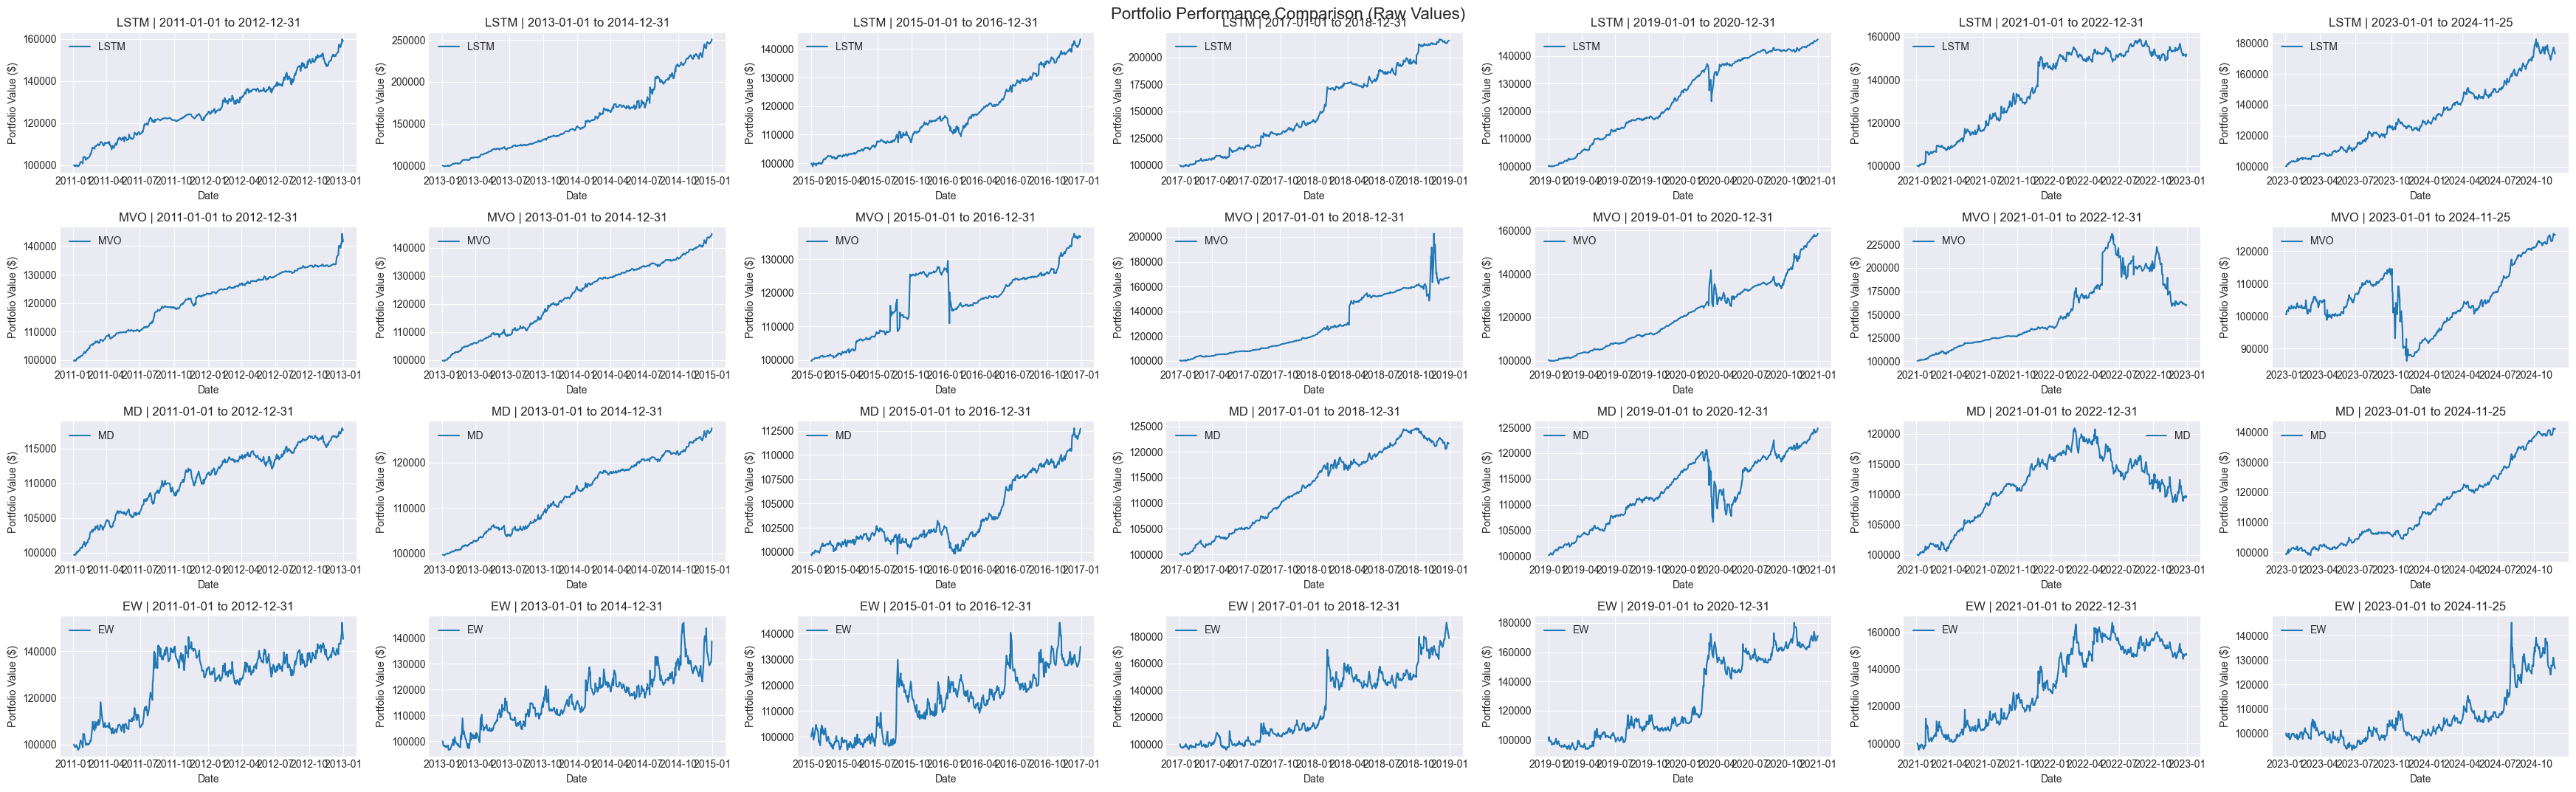

Period 1
LSTM Metrics:
Annualized Return: 0.2668
Annualized Std Dev: 0.0991
Sharpe Ratio: 2.4308
Sortino Ratio: 4.3598
Max Drawdown: 0.0411
% Positive Returns: 55.0000
Profit/Loss Ratio: 1.2583
MVO Metrics:
Annualized Return: 0.2057
Annualized Std Dev: 0.0451
Sharpe Ratio: 4.1556
Sortino Ratio: 9.1409
Max Drawdown: 0.0217
% Positive Returns: 59.7194
Profit/Loss Ratio: 1.5788
MD Metrics:
Annualized Return: 0.0884
Annualized Std Dev: 0.0379
Sharpe Ratio: 2.2368
Sortino Ratio: 3.5736
Max Drawdown: 0.0225
% Positive Returns: 56.1122
Profit/Loss Ratio: 1.1250
EW Metrics:
Annualized Return: 0.2362
Annualized Std Dev: 0.2473
Sharpe Ratio: 0.9771
Sortino Ratio: 2.1000
Max Drawdown: 0.1409
% Positive Returns: 48.0000
Profit/Loss Ratio: 1.2874


Period 2
LSTM Metrics:
Annualized Return: 0.5793
Annualized Std Dev: 0.1630
Sharpe Ratio: 2.8839
Sortino Ratio: 5.6373
Max Drawdown: 0.0515
% Positive Returns: 56.7729
Profit/Loss Ratio: 1.4064
MVO Metrics:
Annualized Return: 0.2038
Annualized Std Dev: 0

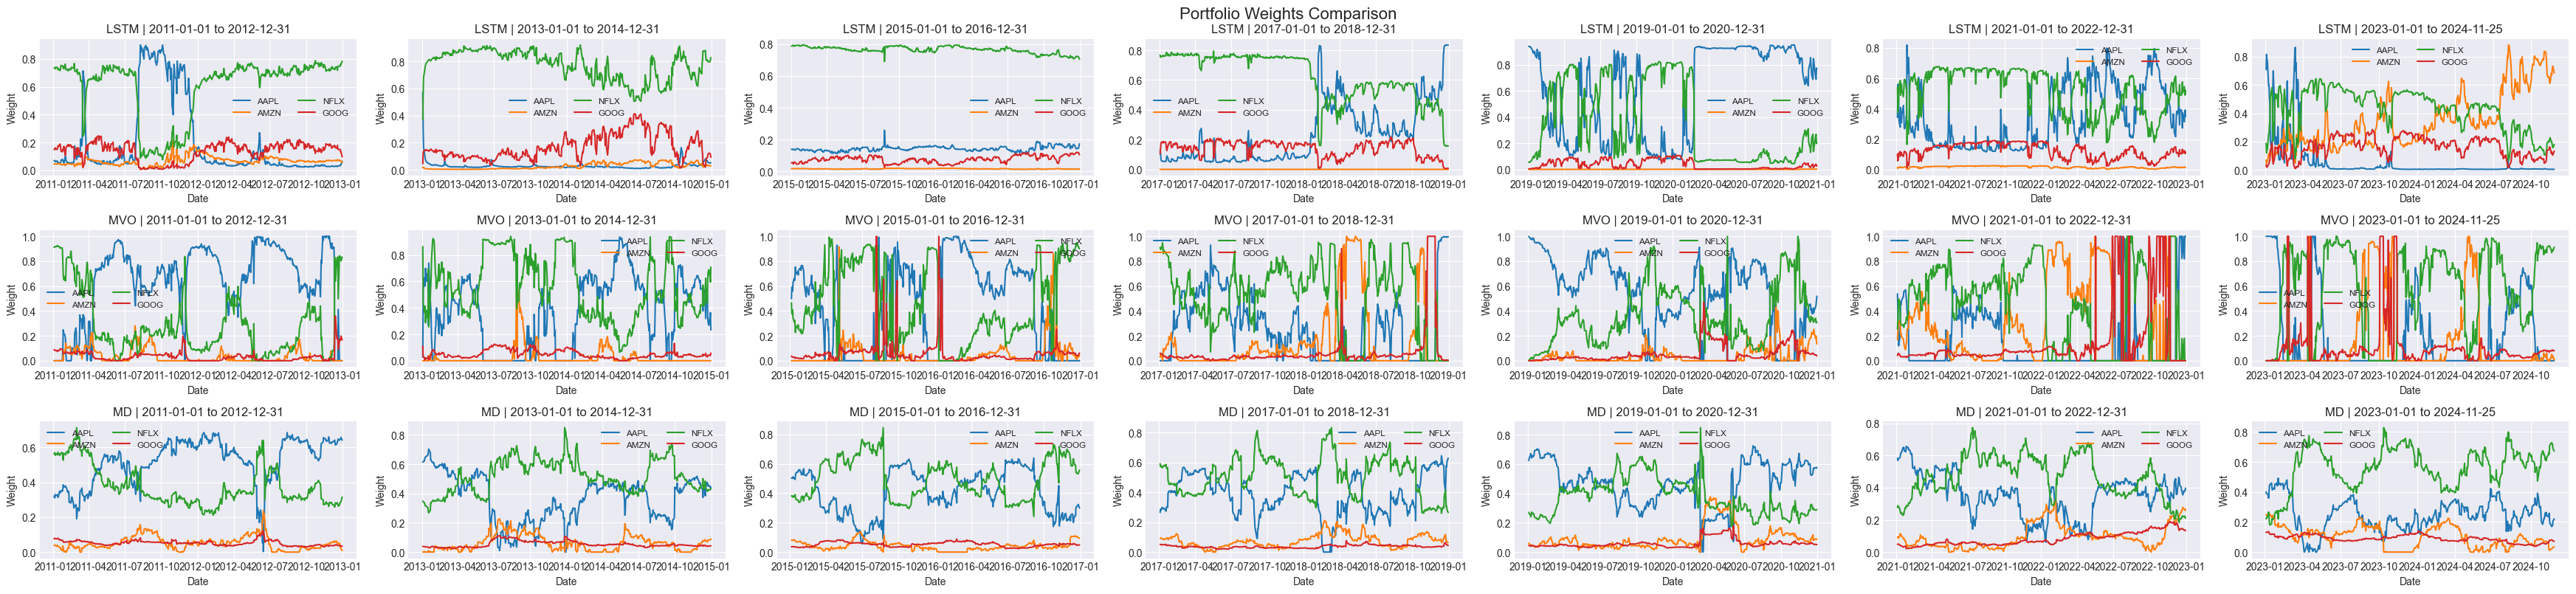

In [19]:
strategies = ['LSTM','MVO', 'MD', 'EW']
plot_performance_comparison(portfolio_histories, periods, strategies)
for i in range(len(mvo_metrics)):
    print(f"Period {i+1}")
    print("LSTM Metrics:")
    for key, value in lstm_metrics[i].items():
        print(f"{key}: {value:.4f}")
    print("MVO Metrics:")
    for key, value in mvo_metrics[i].items():
        print(f"{key}: {value:.4f}")
    print("MD Metrics:")
    for key, value in md_metrics[i].items():
        print(f"{key}: {value:.4f}")
    print("EW Metrics:")
    for key, value in ew_metrics[i].items():
        print(f"{key}: {value:.4f}")
    print("\n")
    strategies = ['LSTM','MVO', 'MD']
asset_names = TICKERS
plot_weights_comparison(portfolio_histories, periods, strategies, asset_names)